# Custom Embeddings using movie reviews dataset

    - This notebook attempts to do multiple things.
        - Train a custom word embedding using the imdb movie reviews data set
        - Train a Deep Learning classifier using learned embeddings and a single layer convolusion architecture
        - Train a Deep Learning classifier using learned embeddings and a multi dimension layer convolusion architecture
    
    - Flow is as follows:
        - Read training reviews
        - Pre-process reviews (clean reviews, sequence them, pad them)
        - Train the reviews using single & multi dimension convolusion layered architecture
        - Compare performance of both the models
        
        - Have fun :)
        
    This notebook assumes that you have the imdb reviews downloaded in unzipped in a directory called imdb along with the notebook. If not then please download the reviews.

## Step 1 -> Utility Functions

### Step 1.0 -> Clean document

In [1]:
import re
import string
from nltk.corpus import stopwords

def clean_doc(doc):
    #split by white space
    tokens = doc.split()
    
    #preprare for char filtering
    re_punc = re.compile('[%s]'%re.escape(string.punctuation))
    
    #remove punctuation from each word
    tokens = [re_punc.sub('',w) for w in tokens]
    
    #remove tokens which are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    
    #filter stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    
    #filter short tokens
    tokens = [word for word in tokens if len(word)>2]
    
    tokens = ' '.join(tokens)
    
    return tokens

### Step 1.1 -> Function to read labels from specified directory

In [2]:
import os
import random

def read_reviews_label (reviews, labels, imdb_dir, label):
    dir_name = os.path.join(imdb_dir, label)
    
    for fname in os.listdir(dir_name):
        if (fname[-4:]=='.txt'):
            f = open (os.path.join(dir_name, fname), encoding='utf-8', mode='r')
            review = f.read()
            cleaned_review = clean_doc(review)
            reviews.append(cleaned_review)
            f.close()
            if (label == 'pos'):
                labels.append(1)
            if (label == 'neg'):
                labels.append(0)
                
    return reviews, labels

### Step 1.2 -> Function to tokenize the reviews

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# tokenize all reviews into tokens where each token represents a word. here we are restricting number of tokens to 9999
def tokenize_document():
    
    tokenizer = Tokenizer(num_words=10000)
    words_per_review = 1000

    tokenizer.fit_on_texts(train_reviews)
    
    train_sequences = tokenizer.texts_to_sequences(train_reviews)
    train_padded_reviews = pad_sequences (train_sequences, maxlen=1000, padding='post')
    
    test_sequences = tokenizer.texts_to_sequences(test_reviews)
    test_padded_reviews = pad_sequences (test_sequences, maxlen=1000, padding='post')
    
    word_index  = tokenizer.word_index
    
    return (word_index, train_padded_reviews, test_padded_reviews, tokenizer)

Using TensorFlow backend.


### Step 1.3 - Utility function to view model performance

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_performance(history):
    ## Visualizing Model Accuracy on Training & Validation data
    trainAccHistory = history.history['acc']
    validationAccHistory = history.history['val_acc']

    plt.plot(trainAccHistory)
    plt.plot(validationAccHistory)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train Vs Validation Accuracy')
    plt.legend(['Train','Validation'])
    plt.show()

## Step 2 -> Read training & test reviews

In [5]:
import numpy as np

imdb_dir = './imdb'
imdb_train_dir = imdb_dir+'/train'

#read positive & negative reviews
train_reviews = []
train_labels = []
train_reviews, train_labels = read_reviews_label(train_reviews, train_labels, imdb_train_dir, 'pos')
train_reviews, train_labels = read_reviews_label(train_reviews, train_labels, imdb_train_dir, 'neg')

#shuffle the reviews and labels list together so that we have a good mix
mapIndexPosition = list(zip(train_reviews, train_labels))
random.shuffle(mapIndexPosition)
train_reviews, train_labels = zip(*mapIndexPosition)

train_labels = np.array(train_labels)

print ('Number of reviews is %d'%(len(train_reviews)))
print ('Number of labels is %d'%(len(train_labels)))

Number of reviews is 25000
Number of labels is 25000


In [6]:
imdb_dir = './imdb'
imdb_test_dir = imdb_dir+'/test'

#read positive & negative reviews
test_reviews = []
test_labels = []
test_reviews, test_labels = read_reviews_label(test_reviews, test_labels, imdb_test_dir, 'pos')
test_reviews, test_labels = read_reviews_label(test_reviews, test_labels, imdb_test_dir, 'neg')

#shuffle the reviews and labels list together so that we have a good mix
mapIndexPosition = list(zip(test_reviews, test_labels))
random.shuffle(mapIndexPosition)
test_reviews, test_labels = zip(*mapIndexPosition)

print ('Number of reviews is %d'%(len(test_reviews)))
print ('Number of labels is %d'%(len(test_labels)))

Number of reviews is 1000
Number of labels is 1000


In [7]:
word_index, train_padded_reviews, test_padded_reviews, tokenizer = tokenize_document()

print ('Vocabulary size is %d and size of padded train reviews is %s'%(len(word_index), train_padded_reviews.shape))
print ('Vocabulary size is %d and size of padded test reviews is %s'%(len(word_index), test_padded_reviews.shape))

Vocabulary size is 116878 and size of padded train reviews is (25000, 1000)
Vocabulary size is 116878 and size of padded test reviews is (1000, 1000)


## Step 3: - Define Deep Learning Model using single layered CNN architecture

### Step 3.0 - Define Model

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Flatten, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils.vis_utils import plot_model

wemodel = Sequential()

wemodel.add(Embedding(input_dim=len(word_index)+1, output_dim=100, input_length=(1000)))

wemodel.add(Conv1D(filters=16, kernel_size=7, activation='relu'))
wemodel.add(MaxPooling1D(pool_size=5))

wemodel.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
wemodel.add(MaxPooling1D(pool_size=5))

wemodel.add(GlobalMaxPooling1D())

wemodel.add(Dense(1, activation='sigmoid'))

wemodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
wemodel.summary()

#plot model and save as png file
#plot_model(model, to_file='reviews_embedding_model.png', show_shapes=True)

#fit the model on training data
history = wemodel.fit (train_padded_reviews, train_labels, validation_split=0.3, epochs=5, batch_size=64)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         11687900  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 994, 16)           11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 198, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 190, 16)           2320      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 16)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dens

### Step 3.1 - Predict Single Layer CNN Model Accuracy on test data

In [9]:
predictedLabels = wemodel.predict_classes(test_padded_reviews)
from sklearn.metrics import accuracy_score
print (accuracy_score(test_labels, predictedLabels))

0.827


### Step 3.2 - Save the Model

In [10]:
from pickle import dump
wemodel.save('movies.reviews.custom.embeddings.model.h5')
dump(tokenizer, open('movies.reviews.custom.embeddings.tokenizer.h5','wb'))

### Step 3.3 - Visualize Model Performance

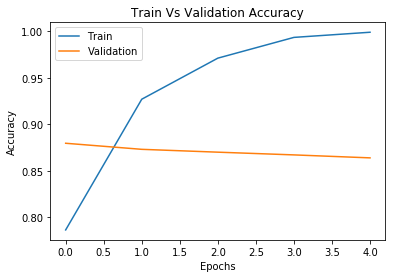

In [11]:
visualize_performance(history)

## Step 4: - Define Deep Learning Model using Multi Dimension CNN layered architecture

### Step 4.0 - Define Model

    - Here we will define a multi layered cnn architecture where each convolusion layer uses a different filter size. Finally before passing the activations to a dense layer we will concatenate the outcome of all of the convolusions
    
    - Here we find that a multi dimension cnn architecture improves model's accuracy from 82 to 86% - an increase of 4%

In [12]:
from keras.models import Input, Model
from keras.layers.merge import concatenate
from keras import regularizers

def multi_dimension_cnn_model(words_per_review, word_index):
    
    #channel 1
    input1 = Input(shape=(1000,))
    embedding1 = Embedding(output_dim=100, input_dim=len(word_index)+1)(input1)
    cnn1d1 = Conv1D(filters=32, kernel_size=7, activation='relu')(embedding1)
    maxpoold1 = MaxPooling1D(pool_size=5)(cnn1d1)
    globalmaxpooling1 = GlobalMaxPooling1D()(maxpoold1)

    #channel 2
    input2 = Input(shape=(1000,))
    embedding2 = Embedding(output_dim=100, input_dim=len(word_index)+1)(input2)
    cnn1d2 = Conv1D(filters=32, kernel_size=9, activation='relu')(embedding2)
    maxpoold2 = MaxPooling1D(pool_size=5)(cnn1d2)
    globalmaxpooling2 = GlobalMaxPooling1D()(maxpoold2)

    #channel 3
    input3 = Input(shape=(1000,))
    embedding3 = Embedding(output_dim=100, input_dim=len(word_index)+1)(input3)
    cnn1d3 = Conv1D(filters=100, kernel_size=12, activation='relu')(embedding3)
    maxpoold3 = MaxPooling1D(pool_size=5)(cnn1d3)
    globalmaxpooling3 = GlobalMaxPooling1D()(maxpoold3)

    merge = concatenate([globalmaxpooling1, globalmaxpooling2, globalmaxpooling3])
    
    outputs = Dense(units=1, activation='sigmoid')(merge)
    
    multi_dim_model = Model(inputs=[input1, input2, input3], outputs= outputs)
    multi_dim_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    multi_dim_model.summary()
    
    return multi_dim_model

multi_dim_model = multi_dimension_cnn_model(1000, word_index)

multi_dim_model_history = multi_dim_model.fit ([train_padded_reviews,train_padded_reviews,train_padded_reviews], train_labels, validation_split=0.3, epochs=5, batch_size=64)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 100)    11687900    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

### Step 4.1 - Predict Multi Layer CNN Model Accuracy on test data

In [13]:
_,acc = multi_dim_model.evaluate([test_padded_reviews,test_padded_reviews,test_padded_reviews], np.array(test_labels))
print ('Accuracy on testing data is %d (percent)'%(acc*100))

1000/1000 [==============================] - 7s 7ms/step
Accuracy on testing data is 86 (percent)


### Step 4.2 - Save the Model

In [14]:
from pickle import dump
multi_dim_model.save('movies.reviews.custom.embeddings.multi.dim.model.h5')
dump(tokenizer, open('movies.reviews.custom.embeddings.multi.dim.tokenizer.h5','wb'))

### Step 4.3 - Visualize Model Performance

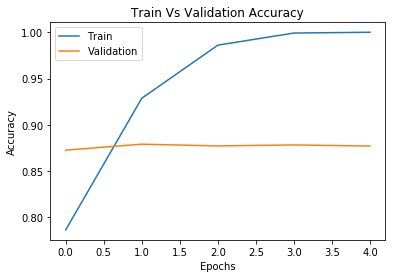

In [15]:
visualize_performance(multi_dim_model_history)

## Step 5 - Prove Quality of Word Embeddings

### Create Matrix of Word Embeddings in our Vocab

    - Read words from our word dictionary
    - Read the embeddings weights from the embedding layer
    - For each word in the dictionary read it's embedding weight and add to a dictionary

In [16]:
import numpy as np
embeddings_index = {}

# get weights from the embedding layer
embeddings = wemodel.layers[0].get_weights()[0]

print ('Shape of weights from embedding layer is ', embeddings.shape)
print ('Size of vocab is ', len(word_index))

for word, i in word_index.items():
    if (i<len(embeddings)):
        embeddings_index[word] =  embeddings[i]

Shape of weights from embedding layer is  (116879, 100)
Size of vocab is  116878


#### Step 4.1 - Save the Reviews Embedding

In [17]:
def save_list (p_embeddings, filename):
    #open file
    file = open (filename, 'w', encoding='utf-8')
    
    for word, i in word_index.items():
        if (i<len(embeddings)):
            embed = embeddings[i, :]
            file.write('%s %s\n' % (word, ' '.join(map(str, embed))))
        
    #close file
    file.close()
    
save_list(embeddings_index, 'custom.movie.reviews.embeddings.100D.txt')

## Step 5 - Reload the saved embeddings and train fresh model using it

In [18]:
embedding_dir = './'
loaded_embeddings_matrix = {}

f = open ('custom.movie.reviews.embeddings.100D.txt','r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    loaded_embeddings_matrix[word]=coefs

f.close()
print ('Found %s word embeddings'%(len(loaded_embeddings_matrix)))

Found 116878 word embeddings


#### Step 5.1 -  Retrain model on loaded embeddings

    - If the new model gives similar performance (in terms of accuracy) while using the saved embeddings; then it validates
    the fact that our word embedding is good and can be used across variety of other natural language processing problems in the movie review space
    - In first run we found that if we use the pre-learned embeddings and DO NOT train the embedding layer again then the accuracy of the model comes around 76% which is around 6% lesser.
    - In second run we found that if we use the pre-learning embeddings and DO train the embedding layer again then the accuracy of the model comes around 85.8%.

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.utils.vis_utils import plot_model

new_model = Sequential()
new_model.add(Embedding(input_dim=(len(word_index)+1), output_dim=100, input_length=(1000)))

new_model.add(Conv1D(filters=16, kernel_size=7, activation='relu'))
new_model.add(MaxPooling1D(pool_size=5))

new_model.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
new_model.add(MaxPooling1D(pool_size=5))

new_model.add(GlobalMaxPooling1D())

new_model.layers[0].set_weights = ([loaded_embeddings_matrix])
new_model.layers[0].trainable = True

new_model.add(Dense(1, activation='sigmoid'))

new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

#plot model and save as png file
#plot_model(model, to_file='reviews_embedding_model.png', show_shapes=True)

#fit the model on training data
history = new_model.fit (train_padded_reviews, train_labels, validation_split=0.3, epochs=5, batch_size=64)

new_model_predicted_labels = new_model.predict_classes(test_padded_reviews)
print ('Accuracy while reusing embeddings is ',(accuracy_score(test_labels, new_model_predicted_labels)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 100)         11687900  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 994, 16)           11216     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 198, 16)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 190, 16)           2320      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 38, 16)            0         
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total para

#### Step 5.2 BatchNormalization layer on the same model

In [27]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, BatchNormalization
from keras.utils.vis_utils import plot_model

batch_norm_model = Sequential()
batch_norm_model.add(Embedding(input_dim=(len(word_index)+1), output_dim=100, input_length=(1000)))

batch_norm_model.add(Conv1D(filters=16, kernel_size=7, activation='relu'))
batch_norm_model.add(BatchNormalization())
batch_norm_model.add(MaxPooling1D(pool_size=5))

batch_norm_model.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
batch_norm_model.add(BatchNormalization())
batch_norm_model.add(MaxPooling1D(pool_size=5))

batch_norm_model.add(GlobalMaxPooling1D())

batch_norm_model.layers[0].set_weights = ([loaded_embeddings_matrix])
batch_norm_model.layers[0].trainable = True

batch_norm_model.add(Dense(1, activation='sigmoid'))

batch_norm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
batch_norm_model.summary()

#plot model and save as png file
#plot_model(model, to_file='reviews_embedding_model.png', show_shapes=True)

#fit the model on training data
history = batch_norm_model.fit (train_padded_reviews, train_labels, validation_split=0.3, epochs=5, batch_size=64)

batch_norm_model_predicted_labels = batch_norm_model.predict_classes(test_padded_reviews)
print ('Accuracy while reusing embeddings with batch normalization is ',(accuracy_score(test_labels, batch_norm_model_predicted_labels)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 100)         11687900  
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 994, 16)           11216     
_________________________________________________________________
batch_normalization_1 (Batch (None, 994, 16)           64        
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 198, 16)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 190, 16)           2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 190, 16)           64        
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 38, 16)            0         
__________

# Leverage Embeddings to find similar words

In [20]:
from gensim.scripts.glove2word2vec import glove2word2vec

#load the GloVe word embeddings file which has a 100 dimension representation for each word. Convert that into a word2vec supported format
glove2word2vec('custom.movie.reviews.embeddings.100D.txt','word2vec.custom.movie.reviews.embeddings.100D.txt')

(116878, 100)

In [21]:
from gensim.models import KeyedVectors

# load the wordvec file
lword2vecmodel = KeyedVectors.load_word2vec_format('word2vec.custom.movie.reviews.embeddings.100D.txt')

In [22]:
# most similar words
print (lword2vecmodel.most_similar(['awful']))

[('mess', 0.8647243976593018), ('appalling', 0.8585390448570251), ('dreadful', 0.8574624061584473), ('connect', 0.8541508913040161), ('disappointment', 0.8540365695953369), ('advance', 0.8538570404052734), ('depicting', 0.8527896404266357), ('evoke', 0.8502072095870972), ('mocking', 0.8485549092292786), ('shameless', 0.8483148217201233)]


#### Visualize embeddings using PCA

    - In tour word embedding there are some 80K words with 100 dimensional embedding. We will select just 50 words and try to visualize them after doing a dimension reduction via PCA

C:\MachineLearning\anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


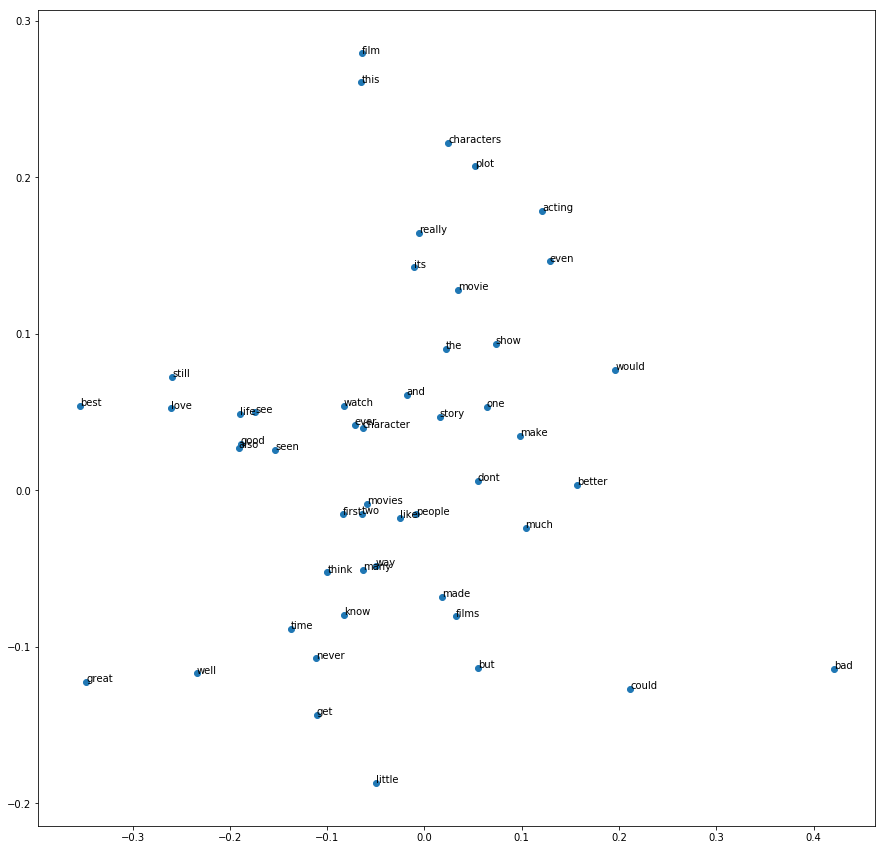

In [23]:
lvocab = lword2vecmodel.wv.vocab
words = []
for i, word in enumerate(lvocab):
    words.append(word)

X = lword2vecmodel[lvocab]

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

z = PCA(n_components=2)
pca_model = z.fit(X)
components = pca_model.transform(X)

num_words_to_show=50

plt.figure(figsize=(15,15))
plt.scatter(components[0:num_words_to_show,0],components[0:num_words_to_show,1])
for i in range(0, num_words_to_show):
    plt.annotate(words[i], xy=(components[i,0],components[i,1]))
plt.show()